In [1]:
import numpy as np
from numpy.linalg import inv
import sympy as sp
import pandas as pd
import math as m
from sympy import collect, simplify, expand, fraction, latex, diff, cancel, nsimplify
from IPython.display import display, Markdown, Math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
theta, theta_d, I, E_bar, w, w_dot = sp.symbols("\\theta \\theta_d I \\bar{E} \omega \dot{\omega}")
e_theta, e_w, e_I = sp.symbols("e_{\\theta} e_{\omega} e_{I} ")
e_theta_dot, e_omega_dot, e_I_dot = sp.symbols("\dot{e_{\\theta}} \dot{e_{\omega}} \dot{e_{I}}")
J, D, M, g, L, N1, N2, Kt = sp.symbols("J D M g L N_1 N_2 K_t") 
La, Ra, Kb, u = sp.symbols("L_a R_a K_b u")
Ja, Da, DL = sp.symbols("J_a D_a D_L")
delta = sp.Symbol("\Delta")

# Problem 1

## part 1

In [3]:
M_val = 5
L_val = 1
Ra_val = 10
La_val = 0.1
g_val = 9.8
Kt_val = 11
Kb_val = 6.36
DL_val = 1
Da_val = 0.1
Ja_val = 2
N1_val = 15
N2_val = 45
theta_d_val = np.pi/6
Ts = 0.01

J_val = Ja_val + (N1_val/N2_val)**2*M_val*L_val**2
D_val = Da_val + (N1_val/N2_val)**2*DL_val
E_bar = Ra_val*g_val*N1_val/(Kt_val*L_val*N2_val)*np.sin(N1_val/N2_val*theta_d_val)

# list of values to be subtituted
lst_subs = [(M,M_val), (L,L_val), (Ra,Ra_val), (La,La_val), (g,g_val), (Kt,Kt_val), (Kb,Kb_val), 
            (D,D_val), (J,J_val), (N1,N1_val), (N2,N2_val), 
            (theta_d, theta_d_val), (delta, Ts)]


# eq 3a
org_3a = w
dot_e_theta = e_w
e_theta_k_1 = e_theta + delta*dot_e_theta # Euler's frwd diff for positional error
e_theta_k_1_subd = e_theta_k_1.subs(lst_subs) # sub numerical values

# function for calculating positional error @ k+1
e_theta_k_1_func = sp.lambdify([e_theta, e_w], e_theta_k_1_subd) 


# eq 3b
org_3b = sp.Eq(J*w_dot + D*w + M*g*L*N1/N2*(sp.sin(N1/N2*(e_theta + theta_d)) 
                                            - sp.sin(N1/N2*theta_d)), Kt*e_I)
dot_e_w = sp.solve(org_3b, w_dot)[0].subs(w, e_w)
e_w_k_1 = e_w + delta*dot_e_w # Euler's frwd diff for angular velocity error
e_w_k_1_subd = e_w_k_1.subs(lst_subs) # sub numerical values

# function for calculating angular vel error @ k+1
e_w_k_1_func = sp.lambdify([e_theta, e_w, e_I, D, J], e_w_k_1_subd) 


# eq 3c
org_3c = sp.Eq(La*e_I_dot + Ra*e_I + Kb*w, u)
dot_e_I = sp.solve(org_3c, e_I_dot)[0].subs(w, e_w)
e_I_k_1 = e_I+ delta*dot_e_I # Euler's frwd diff for armeture current
e_I_k_1_subd = e_I_k_1.subs(lst_subs) # sub numerical values

# function for calculating armeture current error @ k+1
e_I_k_1_func = sp.lambdify([e_w, u], e_I_k_1_subd) 

# find coeffs to exclude input from drift dynamics matrix (f_xk) below
e_I_k_1_coeffs = sp.Poly(e_I_k_1, u).coeffs() 


g_xk = sp.Matrix([[0], [0], [e_I_k_1_coeffs[0]]]) # input dynamics
f_xk = sp.Matrix([[e_theta_k_1], [e_w_k_1], [e_I_k_1_coeffs[1]]]) # drif dynamics

# u is used as a temporary var. makes turning into np array easier
g_xk_func = sp.lambdify([u], g_xk.subs(lst_subs)*u) 
g_xk_subd = g_xk_func(1)

# function for calculating drift dynamics
f_xk_func = sp.lambdify([e_theta, e_w, e_I], f_xk.subs(lst_subs)) 

$e_{\theta_{k+1}} = \;${{e_theta_k_1}}

$e_{\omega_{k+1}} = \;${{e_w_k_1}}

$e_{I_{k+1}} = \;${{e_I_k_1}}

$f(\cdot) =\;$ {{f_xk}}

$g(\cdot) =\;$ {{g_xk}}

## part 2

In [4]:
def ploting(Weights, xk, lst_u, t, NL):
    
    for j in range(NL):
        plt.plot(t, [float((Weights[i][j]).reshape(())) for i in range(len(Weights))])


    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), 
                   loc=2, 
                   borderaxespad=0, 
                   labels=[f"$W_{i}$" for i in range(NL)], 
                   fontsize='xx-large')
    plt.show()

    theta = [(float(xk[i][0]) + theta_d_val) for i in range(len(xk))]
    plt.grid()
    plt.axhline(y=theta_d_val, color='r', linestyle='--')
    plt.plot(t, theta)
    plt.title("Progression of $\\theta$", fontsize=20)
    plt.show()

    plt.plot(t, lst_u+E_bar)
    plt.axhline(y=abs(E_bar), color='r', linestyle='--')
    plt.grid()
    plt.title("$u(k) + \\bar{E}$", fontsize=20)

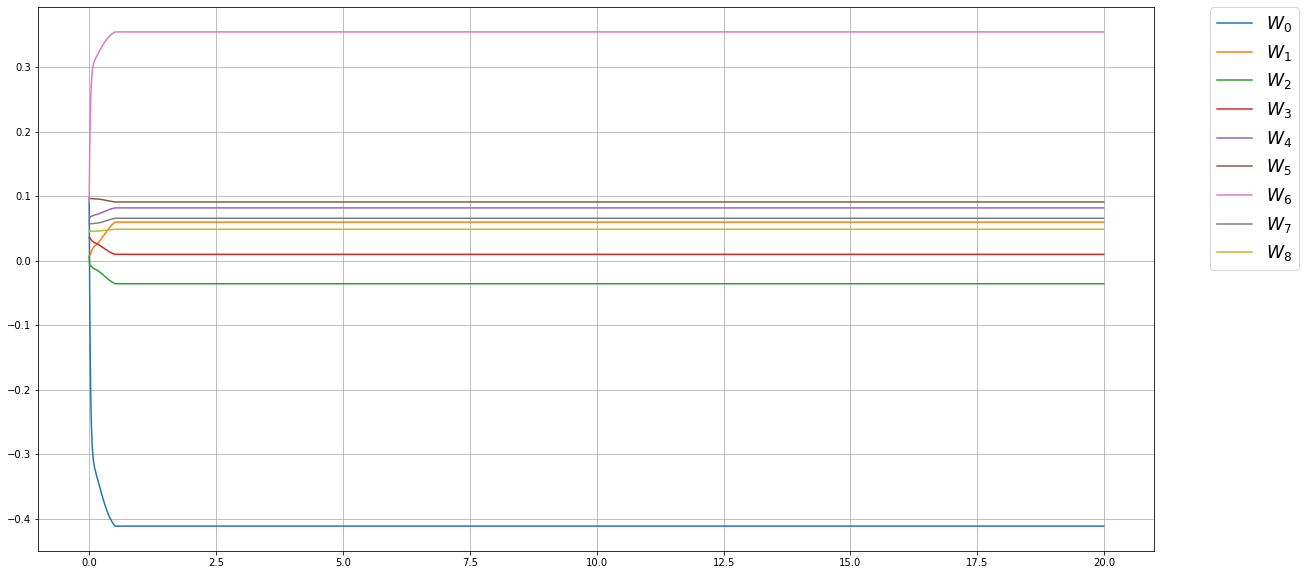

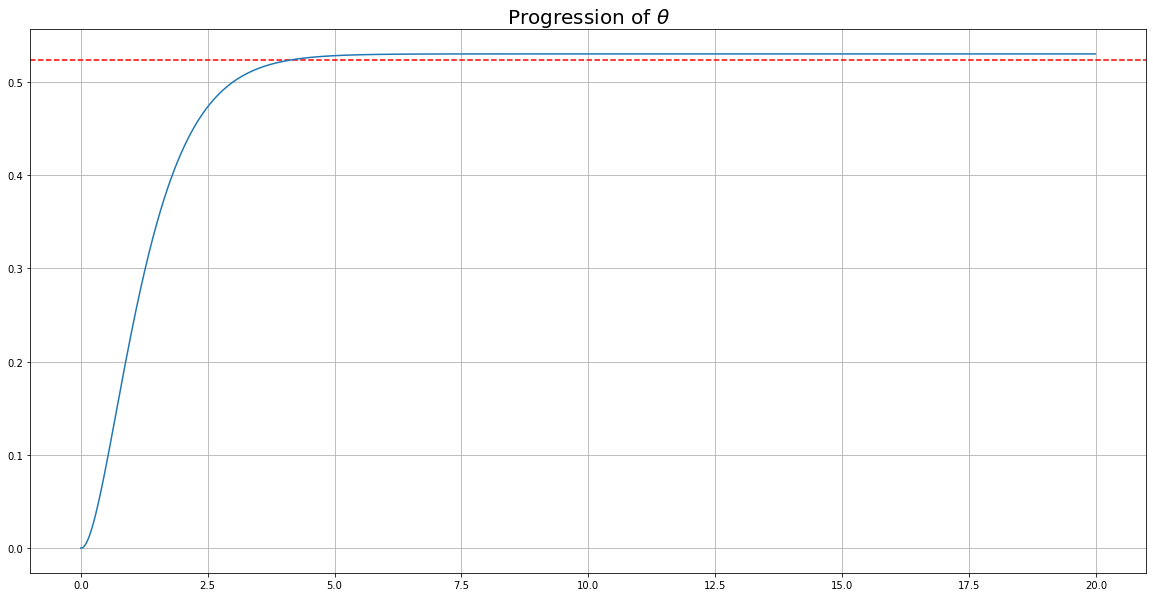

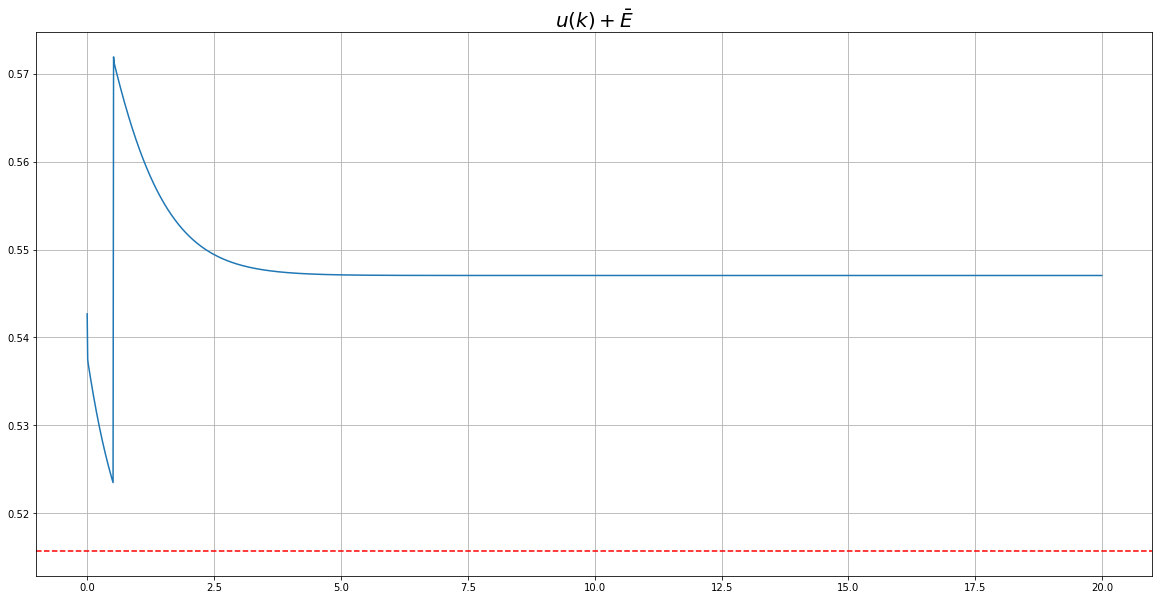

In [5]:
stop_time = 20 # in seconds
cycles = int(stop_time//Ts)
cnt_limit = 1000
eps = 1e-3

gamma = 0.9
alpha = 1

theta0 = 0
w0 = 0
I0 = 0

e_theta0 = theta0 - theta_d_val
e_w0 = w0
e_I0 = I0 - E_bar/Ra_val

R = 0.05
q = np.array([[1, 0, 0], 
            [0, 1, 0],
             [0, 0, 1]])

xk = [np.array([e_theta0, e_w0, e_I0]).reshape(-1,1)]

# basis functions
phi = sp.Matrix([[e_theta, e_w, e_I, 
                 e_theta*e_w, e_theta*e_I, e_w*e_I, 
                 e_theta**2, e_w**2, e_I**2]])

NL = len(phi) # number of neurons

# matrix of derivatives of basis functions with respect to e_theta, e_w and e_I
del_phi = sp.Matrix([[diff(phi, e_theta)], [diff(phi, e_w)], [diff(phi, e_I)]])

phi_func = sp.lambdify([e_theta, e_w, e_I], phi) # function for calculating phi(xk)
del_phi_func = sp.lambdify([e_theta, e_w, e_I], del_phi) # function for calculating derivatives of phi(xk)

# initialsation of value weights
W0 = np.random.uniform(0,0.1,(1, NL)).T 
W = [W0] # list for storing weights

# list for storing phi values initialised with phi(x_0)
lst_phi = [phi_func(*xk[-1].T.tolist()[0])]

# list for storing control inputs
lst_u = [float((-gamma/(2*R)*g_xk_subd.T@del_phi_func(*xk[-1].T.tolist()[0])@W[-1]).reshape(()))] 

t = [0] # list for storing time
k = 0 # time index

# initialisation of weights for comparison in while statement.
# This vector will be updated with every iteration of the value loop
Wji = np.array([0]*NL).reshape(-1,1) 

while (k < cycles):
    Wj_idx = k # index of weights to be used when calculating control input and cost rk in value loop
    k+=1
    t.append(k*Ts)
    Phi = lst_phi[-1].T # Phi(x_k) (column vec)
    xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1]) # Measurment
    lst_phi.append(phi_func(*xk[-1].T.tolist()[0])) # phi(x_(k+1)
    rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_phi[-1]@W[-1] # r(x_k)
    
    cnt = 0 # value loop counter
    # value loop
    while (~(abs(Wji - W[-1]) < eps).all() & (cnt < cnt_limit)):
        k+=1
        t.append(k*Ts)
        Wji = W[-1] # store previous weights for next comparison
        W.append(Wji - alpha*Phi*(Phi.T@Wji - rk)) # gradient decent learning for W_(j+1)^(i+1)
        xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1]) # Measurment
        
        # control input using the weights found before entering value loop
        lst_u.append(float((-gamma/(2*R)*g_xk_subd.T@del_phi_func(*xk[-2].T.tolist()[0])@W[Wj_idx])
                           .reshape(())))
        
        Phi = lst_phi[-1].T # Phi(x_k) (column vec)
        lst_phi.append(phi_func(*xk[-1].T.tolist()[0])) # phi(x_(k+1))
        
        # cost using weights found before entering value loop
        rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_phi[-1]@W[Wj_idx]
        cnt+=1
    
    # append one more time to ensure W, lst_u and t are same length (for ploting)
    W.append(W[-1]) 
    lst_u.append(float((-gamma/(2*R)*g_xk_subd.T@del_phi_func(*xk[-1].T.tolist()[0])@W[-1]).reshape(())))
    
ploting(W, xk, lst_u, t, NL) #function declared above   

## Part 3

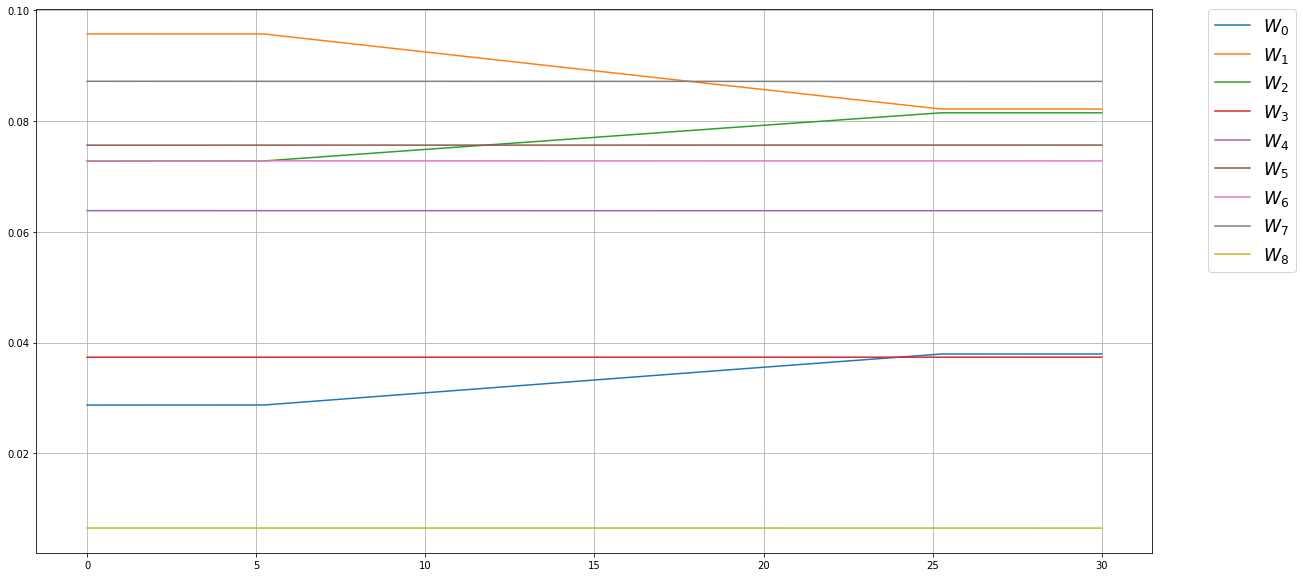

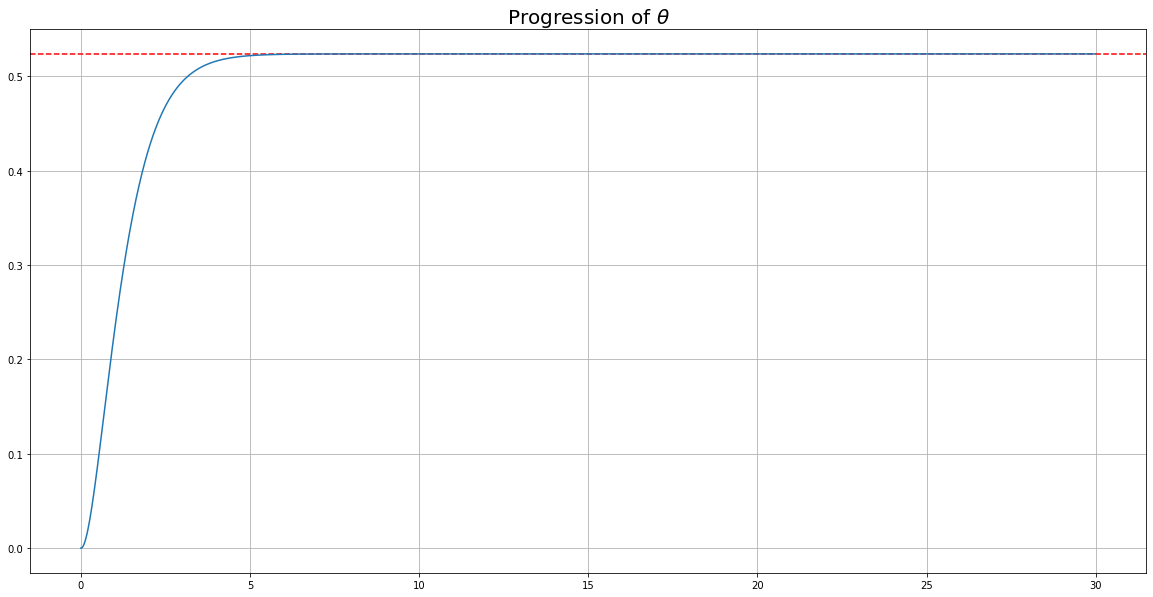

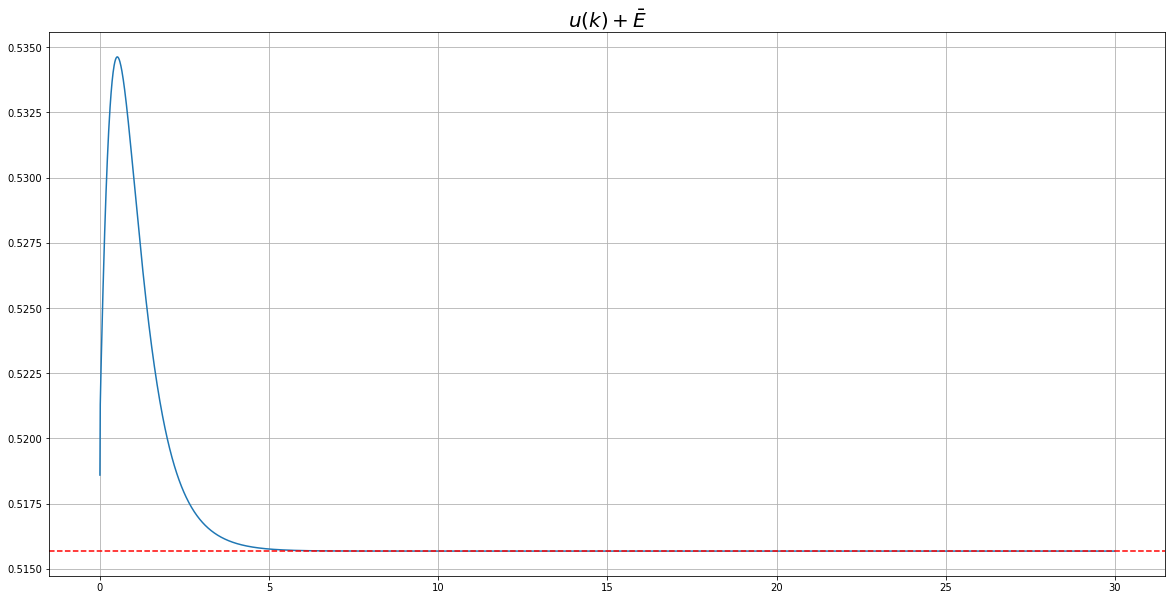

In [6]:
stop_time = 30 # in seconds
cycles = int(stop_time//Ts)
cnt_limit = 1000
eps = 1e-6

gamma = 0.9
alpha = 5
beta = 1

theta0 = 0
w0 = 0
I0 = 0

e_theta0 = theta0 - theta_d_val
e_w0 = w0
e_I0 = I0 - E_bar/Ra_val

R = 0.05
q = np.array([[1, 0, 0], 
            [0, 1, 0],
             [0, 0, 1]])

xk = [np.array([e_theta0, e_w0, e_I0]).reshape(-1,1)]

# basis functions
phi = sp.Matrix([[e_theta, e_w, e_I, 
                 e_theta*e_w, e_theta*e_I, e_w*e_I, 
                 e_theta**2, e_w**2, e_I**2]])
NL = len(phi) # number of neurons

# matrix of derivatives of basis functions with respect to e_theta, e_w and e_I
del_phi = sp.Matrix([[diff(phi, e_theta)], [diff(phi, e_w)], [diff(phi, e_I)]])

phi_func = sp.lambdify([e_theta, e_w, e_I], phi) # function for calculating phi(xk)
del_phi_func = sp.lambdify([e_theta, e_w, e_I], del_phi) # function for calculating derivatives of phi(xk)

# initialsation of value weights
W0 = np.random.uniform(0,0.1,(1, NL)).T
W = [W0] # list for storing weights

# initialsation of policy weights
U0 = np.random.uniform(0,0.1,(1, NL)).T
U = [U0] # list for policy weights

# list for storing phi values initialised with phi(x_0)
lst_phi = [phi_func(*xk[-1].T.tolist()[0])] 

# list for storing control inputs
lst_u = [float((phi_func(*xk[-1].T.tolist()[0])@U[-1]).reshape(()))]

t = [0] # list for storing time
k = 0 # time index

# initialisation of weights for comparison in while statement.
# These vectors will be updated with every iteration of the value/policy loop
Wji = np.array([0]*NL).reshape(-1,1)
Uji = np.array([0]*NL).reshape(-1,1)

while (k < cycles):
    Wj_idx = k # index of weights to be used when calculating control input and cost rk in value loop
    k+=1
    t.append(k*Ts)
    Phi = lst_phi[-1].T # Phi(x_k) (column vec)
    xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1]) # Measurment
    lst_phi.append(phi_func(*xk[-1].T.tolist()[0])) # phi(x_(k+1))
    rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_phi[-1]@W[-1] # r(x_k)
    
    cnt = 0 # value loop counter
    while (~(abs(Wji - W[-1]) < eps).all() & (cnt < cnt_limit)):
        k+=1
        t.append(k*Ts)
        Wji = W[-1] # store previous weights for next comparison
        W.append(Wji - alpha*Phi*(Phi.T@Wji - rk)) # gradient decent learning for W_(j+1)^(i+1)
        U.append(U[-1]) # keeps policy weights list same length as value weights list
        xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1]) # Measurment
        
        # control input using the weights found before entering value loop
        lst_u.append(float((phi_func(*xk[-2].T.tolist()[0])@U[-1]).reshape(())))
        Phi = lst_phi[-1].T # Phi(x_k) (column vec)
        lst_phi.append(phi_func(*xk[-1].T.tolist()[0])) # phi(x_(k+1))
        
        # cost using the weights found before entering value loop
        rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_phi[-1]@W[Wj_idx]
        cnt+=1
    
    # append one more time to ensure W, U, lst_u and t are same length (for ploting)
    W.append(W[-1])
    U.append(U[-1])
    lst_u.append(lst_u[-1])
    
    cnt = 0
    while (~(abs(Uji - U[-1]) < eps).all() & (cnt < cnt_limit)):
        k+=1
        t.append(k*Ts)
        Uji = U[-1]
        
        # gradient decent learning for U_(j+1)^(i+1)
        U.append(Uji - beta*Phi*(2*R*Phi.T@Uji + 
                                 gamma*g_xk_subd.T@del_phi_func(*xk[-1].T.tolist()[0])@W[-1]))
        W.append(W[-1])# keeps value weights list same length as policy weights list
        xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1]) # Measurment
        lst_u.append(float((phi_func(*xk[-2].T.tolist()[0])@U[-1]).reshape(())))
        cnt+=1
        
ploting(U, xk, lst_u, t, NL) 

## Part 4

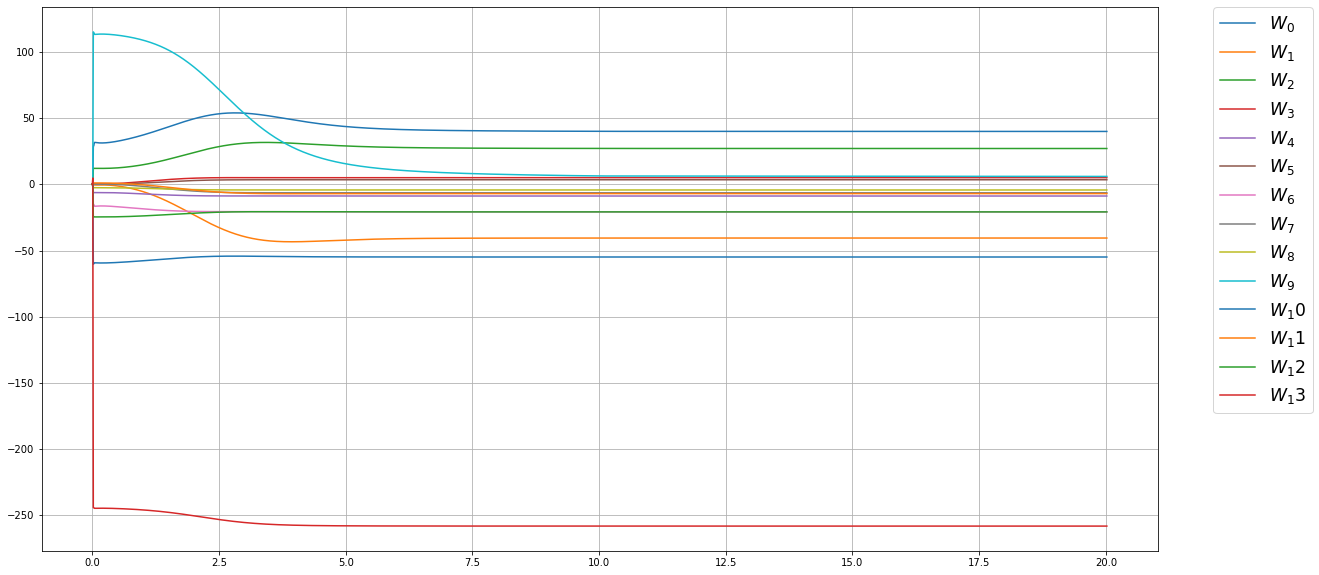

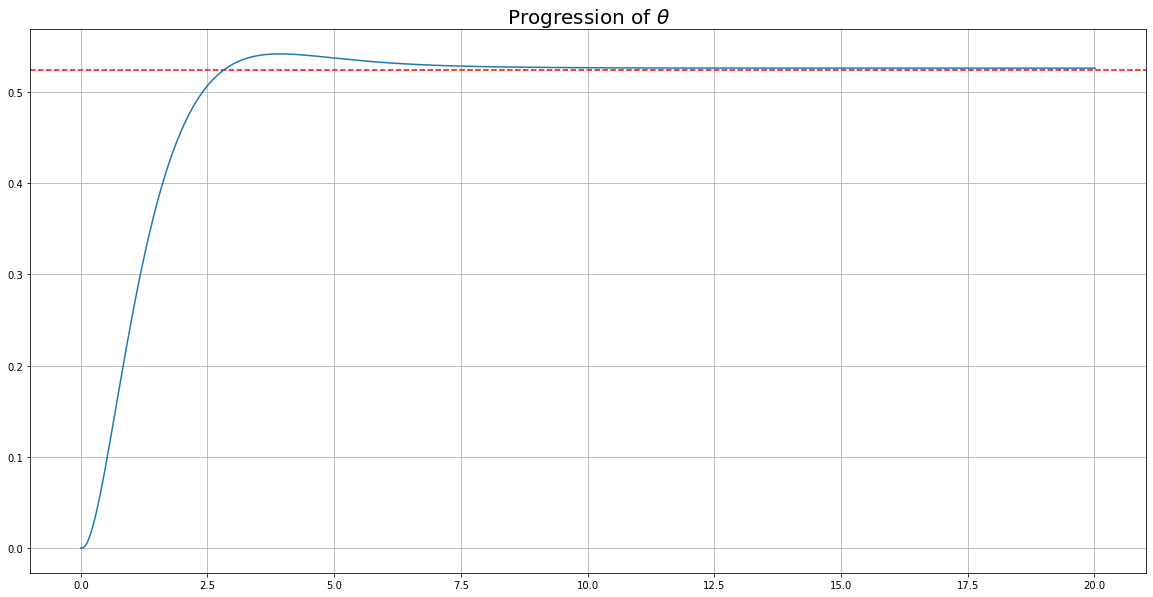

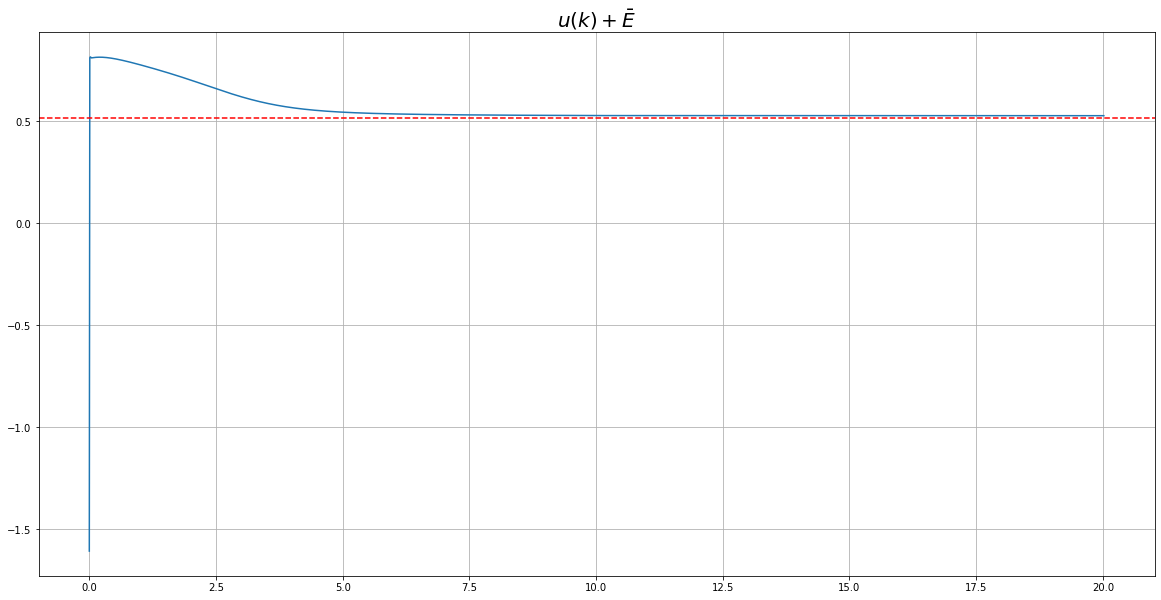

In [7]:
sp.symbols("W(-1:14")
stop_time = 20 # in seconds
cycles = int(stop_time//Ts)
cnt_limit = 1000
eps = 1e-6

gamma = 0.9
alpha = 2

theta0 = 0
w0 = 0
I0 = 0

e_theta0 = theta0 - theta_d_val
e_w0 = w0
e_I0 = I0 - E_bar/Ra_val

xk = [np.array([e_theta0, e_w0, e_I0]).reshape(-1,1)]

R = 0.05
q = np.array([[1, 0, 0], 
            [0, 1, 0],
             [0, 0, 1]])

psi = sp.Matrix([[e_theta, e_w, e_I, 
                 e_theta*e_w, e_theta*e_I, e_w*e_I, 
                 e_theta**2, e_w**2, e_I**2,
                 u, u*e_theta, u*e_w, u*e_I, u**2]])
NL = len(psi)

del_psi_u = diff(psi, u)
W_sym = sp.symbols("W:%d"%NL)
W_sym_mat = sp.Matrix(list(W_sym))
u_eq = sp.solve(sp.Eq((del_psi_u@W_sym_mat)[0], 0), u)[0]

u_func = sp.lambdify([e_theta, e_w, e_I, W_sym[13], W_sym[12], W_sym[11], W_sym[10], W_sym[9]], u_eq)
psi_func = sp.lambdify([e_theta, e_w, e_I, u], psi)
# del_psi_func = sp.lambdify([e_theta, e_w, e_I, u], del_psi) 

W0 = np.random.uniform(0,0.1,(1, NL)).T
W = [W0]

lst_u = [float(u_func(*xk[-1].T.tolist()[0], W[-1][-1], W[-1][-2], W[-1][-3], W[-1][-4], W[-1][-5]).reshape(()))]
lst_psi = [(psi_func(*xk[-1].T.tolist()[0], lst_u[-1]))]

t = [0]
k = 0
Wji = np.array([0]*NL).reshape(-1,1)

while (k < cycles):
    Wj_idx = k
    k+=1
    t.append(k*Ts)
    
    Psi = lst_psi[-1].T # psi(x_k) (column vec)
    
    xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1])
    
    lst_psi.append(psi_func(*xk[-1].T.tolist()[0], lst_u[-1]))
    
    rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_psi[-1]@W[-1]
    
    cnt = 0
    while (~(abs(Wji - W[-1]) < eps).all() & (cnt < cnt_limit)):
        Wji = W[-1]
        W.append(Wji - alpha*Psi*(Psi.T@Wji - rk))
        xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1]) # Measurment
        k+=1
        t.append(k*Ts)
        # might want to use x[-2] with del_phi_func
        lst_u.append(float(u_func(*xk[-1].T.tolist()[0], W[-1][-1], W[-1][-2], W[-1][-3], W[-1][-4], W[-1][-5]).reshape(())))
        Psi = lst_psi[-1].T # psi(x_k) (column vec)
        lst_psi.append(psi_func(*xk[-1].T.tolist()[0], lst_u[-1]))
        rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_psi[-1]@W[Wj_idx]
        cnt+=1
    
    W.append(W[-1])
    lst_u.append(float(u_func(*xk[-1].T.tolist()[0], W[-1][-1], W[-1][-2], W[-1][-3], W[-1][-4], W[-1][-5]).reshape(())))
    
ploting(W, xk, lst_u, t, NL)